In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
geo = "GSE68951"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Leidinger2015", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [3]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [4]:
table

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
VALUE,1.854979,2.184182,2.532296,1.518052,1.510107,4.779461,1.463735,0.701141,1.884349,3.091228,...,5.084469,5.292274,0.268966,2.060832,7.297528,2.252402,5.674228,1.410002,3.727455,1.370078
VALUE,1.469763,2.320244,2.111889,1.617264,3.138606,3.836508,1.473691,1.036632,2.182694,3.226966,...,4.741217,4.961900,0.268966,1.871114,8.545123,2.045075,5.927078,1.427917,2.450359,1.357766
VALUE,1.449375,2.510285,2.083508,1.235886,2.961309,4.034239,1.729450,1.238367,2.191353,2.853613,...,4.636542,5.069766,0.137944,1.633985,7.760185,2.167678,5.892667,1.123662,2.571076,1.066838
VALUE,1.777522,2.724679,3.012722,1.390768,1.634918,3.507631,1.582395,0.762787,2.277530,2.493348,...,6.048589,6.561372,-1.470349,2.206143,4.255906,1.673774,2.802465,1.140461,3.310383,1.443592
VALUE,1.538218,2.030510,2.470375,1.563558,2.854814,3.221865,1.322348,1.001364,2.293578,3.162074,...,4.568712,5.488843,-0.545426,2.377511,8.967807,2.322869,5.674228,1.234841,2.518547,1.486707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1.208435,2.033658,1.886196,1.508165,2.806061,4.284687,1.980155,0.809298,1.840813,2.987895,...,3.919363,4.096354,-0.503736,1.729212,8.486483,2.491044,6.143936,1.115169,3.132605,0.989683
VALUE,1.684514,2.080012,2.059345,1.417107,3.538179,3.773553,1.740067,0.455577,2.015791,2.571232,...,4.280475,4.774863,-0.091713,1.648940,6.817383,2.128892,6.143936,1.317900,4.247214,0.965132
VALUE,1.551354,2.096305,1.840612,1.367924,1.604824,4.088314,1.542105,0.745438,1.967710,2.949619,...,4.700858,5.330010,-0.115405,1.904973,7.363005,2.170307,5.448143,1.468406,4.037153,0.933782
VALUE,1.588192,2.448541,2.439351,1.791408,1.701302,2.642355,1.812207,0.787968,2.182013,3.007374,...,5.683202,6.306057,0.434612,1.962911,8.027675,2.026171,6.660830,1.260015,3.437391,1.324230


### Seperate case and controls

In [5]:
set([k.metadata["characteristics_ch1"][1] for k in list(data.gsms.values())])

{'disease: lung cancer', 'disease: non-cancerous lung disease (control)'}

In [6]:
sick = np.array(["lung cancer" in k.metadata["characteristics_ch1"][1] for k in list(data.gsms.values())])
controls = 1 - sick

In [7]:
sum(controls)

12

### Drop NAN

In [8]:
table = table.dropna(1)

C:\Users\OLEFRE~1\AppData\Local\Temp/ipykernel_17464/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [9]:
X = table

In [10]:
X

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
VALUE,1.854979,2.184182,2.532296,1.518052,1.510107,4.779461,1.463735,0.701141,1.884349,3.091228,...,5.084469,5.292274,0.268966,2.060832,7.297528,2.252402,5.674228,1.410002,3.727455,1.370078
VALUE,1.469763,2.320244,2.111889,1.617264,3.138606,3.836508,1.473691,1.036632,2.182694,3.226966,...,4.741217,4.961900,0.268966,1.871114,8.545123,2.045075,5.927078,1.427917,2.450359,1.357766
VALUE,1.449375,2.510285,2.083508,1.235886,2.961309,4.034239,1.729450,1.238367,2.191353,2.853613,...,4.636542,5.069766,0.137944,1.633985,7.760185,2.167678,5.892667,1.123662,2.571076,1.066838
VALUE,1.777522,2.724679,3.012722,1.390768,1.634918,3.507631,1.582395,0.762787,2.277530,2.493348,...,6.048589,6.561372,-1.470349,2.206143,4.255906,1.673774,2.802465,1.140461,3.310383,1.443592
VALUE,1.538218,2.030510,2.470375,1.563558,2.854814,3.221865,1.322348,1.001364,2.293578,3.162074,...,4.568712,5.488843,-0.545426,2.377511,8.967807,2.322869,5.674228,1.234841,2.518547,1.486707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1.208435,2.033658,1.886196,1.508165,2.806061,4.284687,1.980155,0.809298,1.840813,2.987895,...,3.919363,4.096354,-0.503736,1.729212,8.486483,2.491044,6.143936,1.115169,3.132605,0.989683
VALUE,1.684514,2.080012,2.059345,1.417107,3.538179,3.773553,1.740067,0.455577,2.015791,2.571232,...,4.280475,4.774863,-0.091713,1.648940,6.817383,2.128892,6.143936,1.317900,4.247214,0.965132
VALUE,1.551354,2.096305,1.840612,1.367924,1.604824,4.088314,1.542105,0.745438,1.967710,2.949619,...,4.700858,5.330010,-0.115405,1.904973,7.363005,2.170307,5.448143,1.468406,4.037153,0.933782
VALUE,1.588192,2.448541,2.439351,1.791408,1.701302,2.642355,1.812207,0.787968,2.182013,3.007374,...,5.683202,6.306057,0.434612,1.962911,8.027675,2.026171,6.660830,1.260015,3.437391,1.324230


In [11]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [12]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [13]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [14]:
mirnas.iloc[lowest], pvalues

(507       hsa-miR-3152
 368    hsa-miR-3647-5p
 508       hsa-miR-3151
 836       hsa-miR-3617
 397       hsa-miR-4261
 Name: ID_REF, dtype: object,
 array([4.06302756e-18, 1.17934476e-16, 4.26805231e-10, 1.11760527e-09,
        1.14133290e-09]))

### F-test

In [15]:
t3 = table

In [16]:
f, p = f_classif(t3, sick)

In [17]:
np.mean(p)

0.29722361531307223

### ANOVA

In [18]:
t3

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
VALUE,1.854979,2.184182,2.532296,1.518052,1.510107,4.779461,1.463735,0.701141,1.884349,3.091228,...,5.084469,5.292274,0.268966,2.060832,7.297528,2.252402,5.674228,1.410002,3.727455,1.370078
VALUE,1.469763,2.320244,2.111889,1.617264,3.138606,3.836508,1.473691,1.036632,2.182694,3.226966,...,4.741217,4.961900,0.268966,1.871114,8.545123,2.045075,5.927078,1.427917,2.450359,1.357766
VALUE,1.449375,2.510285,2.083508,1.235886,2.961309,4.034239,1.729450,1.238367,2.191353,2.853613,...,4.636542,5.069766,0.137944,1.633985,7.760185,2.167678,5.892667,1.123662,2.571076,1.066838
VALUE,1.777522,2.724679,3.012722,1.390768,1.634918,3.507631,1.582395,0.762787,2.277530,2.493348,...,6.048589,6.561372,-1.470349,2.206143,4.255906,1.673774,2.802465,1.140461,3.310383,1.443592
VALUE,1.538218,2.030510,2.470375,1.563558,2.854814,3.221865,1.322348,1.001364,2.293578,3.162074,...,4.568712,5.488843,-0.545426,2.377511,8.967807,2.322869,5.674228,1.234841,2.518547,1.486707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1.208435,2.033658,1.886196,1.508165,2.806061,4.284687,1.980155,0.809298,1.840813,2.987895,...,3.919363,4.096354,-0.503736,1.729212,8.486483,2.491044,6.143936,1.115169,3.132605,0.989683
VALUE,1.684514,2.080012,2.059345,1.417107,3.538179,3.773553,1.740067,0.455577,2.015791,2.571232,...,4.280475,4.774863,-0.091713,1.648940,6.817383,2.128892,6.143936,1.317900,4.247214,0.965132
VALUE,1.551354,2.096305,1.840612,1.367924,1.604824,4.088314,1.542105,0.745438,1.967710,2.949619,...,4.700858,5.330010,-0.115405,1.904973,7.363005,2.170307,5.448143,1.468406,4.037153,0.933782
VALUE,1.588192,2.448541,2.439351,1.791408,1.701302,2.642355,1.812207,0.787968,2.182013,3.007374,...,5.683202,6.306057,0.434612,1.962911,8.027675,2.026171,6.660830,1.260015,3.437391,1.324230


In [19]:
X = np.array(sick).reshape(-1, 1)

In [20]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [21]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.018322698781242038

### Mean-variance-plot

In [22]:
np.mean(table)

0       1.627729
1       2.374215
2       2.427747
3       1.480994
4       2.163062
          ...   
1200    2.174952
1201    5.509455
1202    1.305399
1203    2.963962
1204    1.318832
Length: 1205, dtype: float64

In [23]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [24]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

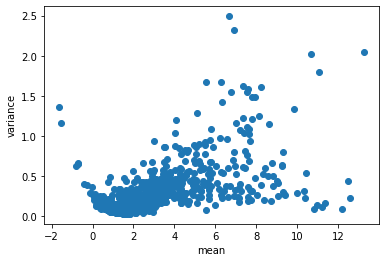

In [25]:
mean_variance_plot(table)

### Log transformation

In [26]:
log_table = table #np.log2(table)

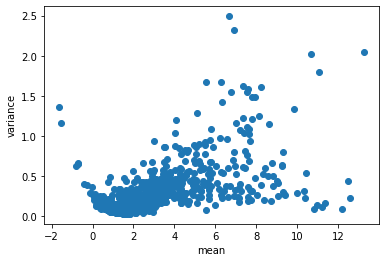

In [27]:
mean_variance_plot(log_table)

### Loess regression

In [28]:
lowess = LowessRegression(sigma=1, span=0.1)

In [29]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [30]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

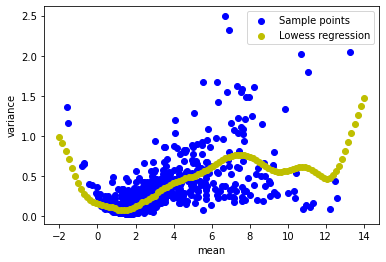

In [31]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [32]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [33]:
log_table /= np.sqrt(adj_var)

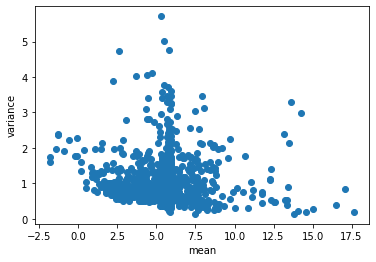

In [34]:
mean_variance_plot(log_table)

### Remove mean

In [35]:
norm_log_table = log_table - np.mean(log_table)
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

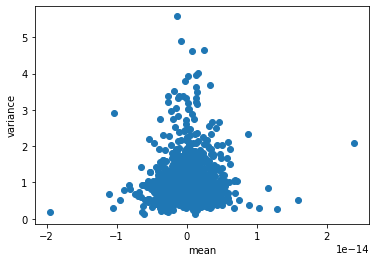

In [36]:
mean_variance_plot(norm_log_table)

### PCA

In [37]:
pca = decomposition.PCA(n_components=10)

In [38]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [39]:
pca.explained_variance_ratio_

array([0.22882519, 0.13164587, 0.06114179, 0.03834914, 0.03301339,
       0.0295242 , 0.02329869, 0.02162835, 0.01724176, 0.01619625])

In [40]:
components = pca.transform(norm_log_table)

In [41]:
components.shape

(215, 10)

In [42]:
sum(controls)

12

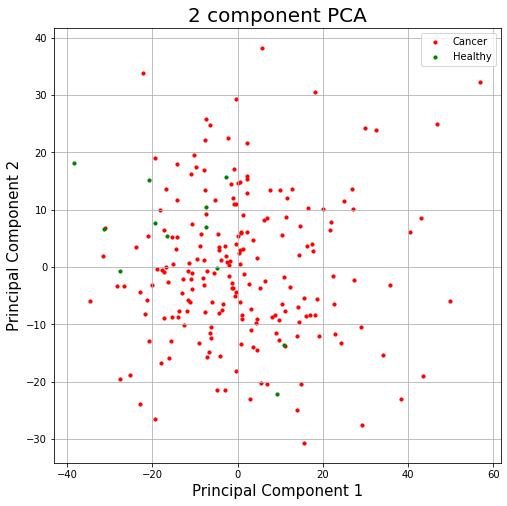

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [44]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

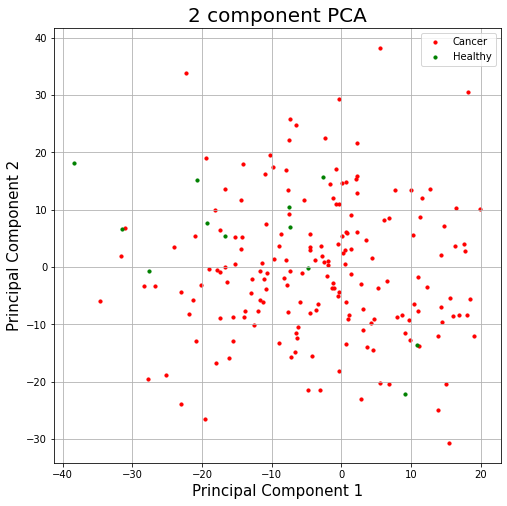

In [45]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [46]:
list(data.gsms.values())[5].metadata

{'title': ['A_6_489'],
 'geo_accession': ['GSM1688373'],
 'status': ['Public on Sep 24 2015'],
 'submission_date': ['May 15 2015'],
 'last_update_date': ['Sep 24 2015'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['RNA from plasma'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['tissue: plasma',
  'disease: lung cancer',
  'patient id: A',
  'timepoint: 6'],
 'treatment_protocol_ch1': ['Blood of lung cancer patients was drawn directly before tumor resection (TP1), ~ two weeks after tumor resection (TP2) and then ~ three months (TP3), six months (TP4), nine months (TP5), 12 months (TP6), 15 months (TP7) and 18 months (TP8) after tumor resection.  Stored at -20 degree'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['We first treated 100Âµl plasma with 10Âµg Heparinase I (Sigma) and 100U RNaseOUTTM (Life Technologies, CatNo 10777-019) and incubated the mixture at 25Â°C for 1 hour. Nuclease free water (Life Technologie

In [47]:
sex = np.array(["Female" in k.metadata["characteristics_ch1"][1] for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])
age = np.array([float(k.metadata["characteristics_ch1"][2].split(" ")[1].replace("NA", "NaN")) for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])

ValueError: could not convert string to float: 'id:'

In [ ]:
covars = pd.DataFrame(np.array([sex, age]).transpose(), columns=["sex", "age"])

In [ ]:
covars = covars.fillna(covars.mean())

In [ ]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

In [ ]:
adj_norm_log_table = norm_log_table - linreg.predict(covars)

# PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

In [ ]:
pca.fit(adj_norm_log_table)

In [ ]:
components = pca.transform(adj_norm_log_table)

In [ ]:
components

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

In [ ]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [ ]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

In [ ]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [ ]:
lookup_table = data.gpls["GPL16770"].table

In [ ]:
lookup_table.head()

In [ ]:
lookup_table = lookup_table.set_index("ID")

In [ ]:
mirna_ids = lookup_table.loc[mirnas]["miRNA_ID"]

In [ ]:
from Scripts import converters

In [ ]:
sequences = converters.canonical_to_seq(mirnas, True)

In [ ]:
sequences.count(None)

In [ ]:
sequences = np.array(sequences)
mask = sequences != None
sequences = sequences[mask]
adj_norm_log_table = norm_log_table.loc[:, mask]

In [ ]:
adj_norm_log_table.columns = sequences
adj_norm_log_table = adj_norm_log_table.loc[:,~adj_norm_log_table.columns.duplicated()]
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

In [ ]:
adj_norm_log_table.to_csv("../TransformedData/Leidinger2015_adjusted.csv", index=False)